In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy
from astropy.io import fits
from astropy.table import Table
import richardsplot
import sklearn
%matplotlib inline

In [2]:
def trevorFit(data, fit):
    trevorFit = np.array([]).reshape(0, 2)
    for scat in data: 
        r = np.sqrt((scat[1]-fit[:,0])**2 + (scat[0]-fit[:,1])**2) #dist of vla point from each point along fit
        delta = np.array([fit[np.argmin(r), 0], fit[np.argmin(r), 1]])
        trevorFit = np.concatenate((trevorFit, np.atleast_2d(delta)))
    return np.atleast_2d(trevorFit[:,0]).T, np.atleast_2d(trevorFit[:,1]).T


def spaghettify(arr, marker=[], data_dist=[]): #data dist is an array of x-coords along fit
    d = 0
    pts = np.array([]).reshape(0,2)
    bins = np.zeros((len(data_dist), 1))
    xp = 0 #initial left bound
    for i in range(arr.shape[0]-1):
        dp = d
        d += np.sqrt((arr[i+1,0]-arr[i,0])**2 + (arr[i+1,1]-arr[i,1])**2)
        for p in range(len(marker)):
            if (dp < marker[p] < d):
                x = arr[i,0]
                pts = np.vstack((pts, np.array([arr[i,0], arr[i,1]])))
                #Now add all of the tFit points in front of the last p
                #and behind this p -- just the x-coord will work for a mask
                sort = ((xp<data_dist)&(data_dist<x))
                bins[sort] = (p-1)
                xp = x
    if len(marker)>0:
        bins[data_dist>x] = max(bins)+2
        bins -= min(bins) #rescale so that 'leftmost' point is in section 0
        return pts, bins
    return d

In [3]:
infile = 'SDSSRMMedianCIVParams.csv'
df = pd.read_csv(infile)
print(df.head())

   RMID  Median_CIV_Blueshift  Median_CIV_EQW
0    10              2788.040         52.9572
1    11               114.225        156.4920
2    19               360.118        115.8840
3    31               290.420        152.8945
4    34              1099.710        101.4990


In [4]:
X = df[['Median_CIV_Blueshift','Median_CIV_EQW']].values
print(X.shape)
print(X)

(128, 2)
[[ 2.788040e+03  5.295720e+01]
 [ 1.142250e+02  1.564920e+02]
 [ 3.601180e+02  1.158840e+02]
 [ 2.904200e+02  1.528945e+02]
 [ 1.099710e+03  1.014990e+02]
 [ 8.983690e+02  1.205695e+02]
 [ 3.988310e+02  2.660275e+02]
 [ 2.981720e+02  1.034780e+02]
 [-2.323270e+01  2.333250e+02]
 [ 6.060110e+02  1.835250e+02]
 [ 1.665050e+02  1.898780e+02]
 [ 1.332060e+03  1.041160e+02]
 [ 6.544140e+02  9.378500e+01]
 [ 1.819850e+02  1.207610e+02]
 [ 3.988310e+02  1.385700e+02]
 [ 6.253670e+02  1.576670e+02]
 [-4.840330e+01  1.594880e+02]
 [ 9.312680e+02  1.448360e+02]
 [ 6.873130e+02  1.045075e+02]
 [ 5.421740e+01  1.562360e+02]
 [-3.078390e+02  2.455320e+02]
 [ 6.960340e+02  1.262565e+02]
 [-6.003150e+01  2.660200e+02]
 [ 1.384340e+03  1.082265e+02]
 [ 1.384270e+02  1.872360e+02]
 [ 1.756060e+03  6.730940e+01]
 [ 6.486000e+02  1.149455e+02]
 [ 4.472350e+02  1.426850e+02]
 [ 2.516830e+02  1.782580e+02]
 [ 3.772550e+03  6.461085e+01]
 [ 3.136530e+02  2.035270e+02]
 [-9.874470e+01  1.919340e+02]

In [5]:
x = X[:,0]
y = X[:,1]

Text(0, 0.5, 'EQW')

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


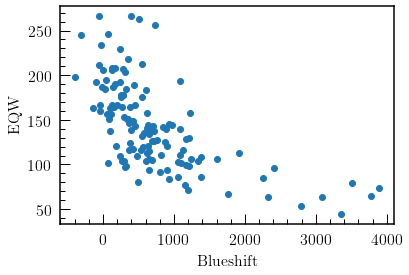

In [6]:
plt.scatter(x, y)
plt.xlabel('Blueshift')
plt.ylabel('EQW')

In [7]:
z = np.arange(min(x),max(x),100)
print(z)

[-3.969170e+02 -2.969170e+02 -1.969170e+02 -9.691700e+01  3.083000e+00
  1.030830e+02  2.030830e+02  3.030830e+02  4.030830e+02  5.030830e+02
  6.030830e+02  7.030830e+02  8.030830e+02  9.030830e+02  1.003083e+03
  1.103083e+03  1.203083e+03  1.303083e+03  1.403083e+03  1.503083e+03
  1.603083e+03  1.703083e+03  1.803083e+03  1.903083e+03  2.003083e+03
  2.103083e+03  2.203083e+03  2.303083e+03  2.403083e+03  2.503083e+03
  2.603083e+03  2.703083e+03  2.803083e+03  2.903083e+03  3.003083e+03
  3.103083e+03  3.203083e+03  3.303083e+03  3.403083e+03  3.503083e+03
  3.603083e+03  3.703083e+03  3.803083e+03]


In [8]:
from scipy.interpolate import interp2d    
#fit = interp2d(x, y, z, kind='cubic')
fit = np.poly1d(np.polyfit(x,y,3))

In [9]:
print(fit)
print(fit(z))

            3             2
-1.608e-09 x + 2.009e-05 x - 0.08466 x + 185.2
[222.08685467 212.1688629  202.68127698 193.61444836 184.95872847
 176.70446875 168.84202066 161.36173563 154.25396509 147.5090605
 141.11737329 135.0692549  129.35505678 123.96513037 118.8898271
 114.11949842 109.64449578 105.4551706  101.54187434  97.89495843
  94.50477431  91.36167343  88.45600723  85.77812715  83.31838463
  81.0671311   79.01471802  77.15149683  75.46781896  73.95403585
  72.60049895  71.3975597   70.33556954  69.40487991  68.59584225
  67.89880801  67.30412862  66.80215552  66.38324016  66.03773398
  65.75598842  65.52835492  65.34518492]


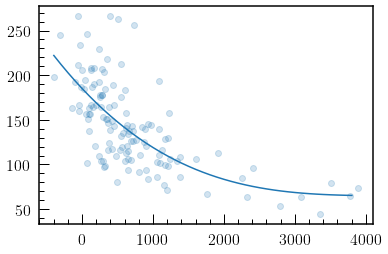

In [10]:
plt.scatter(x, y, alpha=0.2)
plt.plot(z, fit(z))

Might try to use the right end of this fit and combine with the next fit on other end of data

In [11]:
x2 = X[:,1]
y2 = X[:,0]

In [12]:
fit2 = np.poly1d(np.polyfit(x2,y2,3))
print(fit2)

            3          2
-0.0007917 x + 0.4889 x - 99.85 x + 7005


In [13]:
z2 = np.arange(min(x2),max(x2),5)
print(z2)

[ 44.6439  49.6439  54.6439  59.6439  64.6439  69.6439  74.6439  79.6439
  84.6439  89.6439  94.6439  99.6439 104.6439 109.6439 114.6439 119.6439
 124.6439 129.6439 134.6439 139.6439 144.6439 149.6439 154.6439 159.6439
 164.6439 169.6439 174.6439 179.6439 184.6439 189.6439 194.6439 199.6439
 204.6439 209.6439 214.6439 219.6439 224.6439 229.6439 234.6439 239.6439
 244.6439 249.6439 254.6439 259.6439 264.6439]


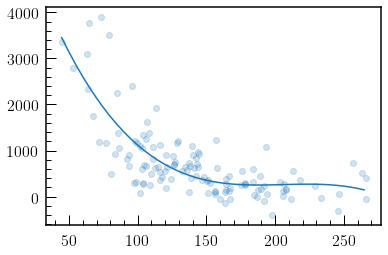

In [14]:
plt.scatter(x2, y2, alpha=0.2)
plt.plot(z2, fit2(z2))

Now load in VLA data and fit to this curve to start

In [33]:
infile2 = '../SpringFinalFigs_moreParams.csv'
df2 = pd.read_csv(infile2)

#New blueshift/eqw values based on ICA reconstructions from Angelica
infile3 = 'AllVLACIVParams.csv'
df3 = pd.read_csv(infile3)
ica_blueshift = df3[['CIV_Blueshift (km/s)']].values
ica_eqw = df3[['CIV_EQW']].values

In [34]:
vla_data = df2[['VOFF_CIV_PEAK_2', 'EW_CIV_2']].values

fit3 = np.poly1d(np.polyfit(vla_data[:,1], vla_data[:,0], 5))
z3 = np.arange(min(vla_data[:,1]), max(vla_data[:,1]), .1)

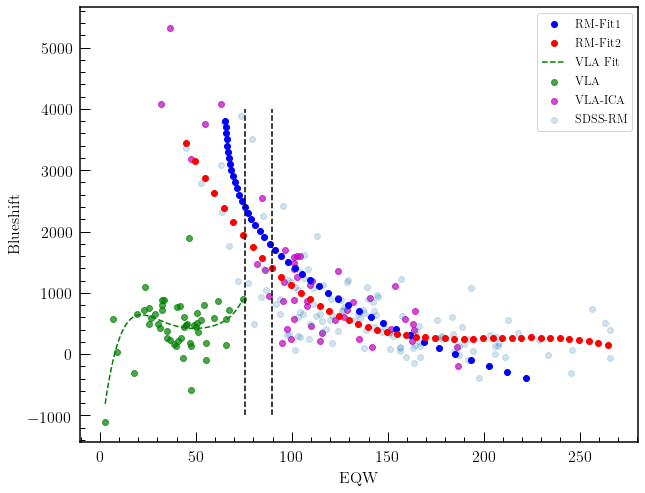

In [40]:
plt.figure(figsize=(10,8))
plt.scatter(vla_data[:,1], vla_data[:,0], label="VLA", color='g', alpha=0.7)
plt.scatter(ica_eqw, ica_blueshift, label="VLA-ICA", color='m', alpha=0.7)
plt.scatter(x2, y2, alpha=0.2, label="SDSS-RM")
plt.plot(fit(z), z, 'bo', label="RM-Fit1")
plt.plot(z2, fit2(z2), 'ro', label="RM-Fit2")
plt.plot(z3, fit3(z3), '--g', label="VLA Fit")
plt.xlabel("EQW")
plt.ylabel("Blueshift")
plt.legend(loc="best")

#Draw out which fit points to keep for each, do another fit for those points
plt.plot([fit(z)[28],fit(z)[28]], [-1000,4000], '--k')
plt.plot([z2[9],z2[9]], [-1000,4000], '--k')

Black lines indicate the breakpoints in the data we want to use.  In other words, we want to use all of the blue to the left of the leftmost black line, and all of the red to the right of the rightmost black line to form our new line of best fit.

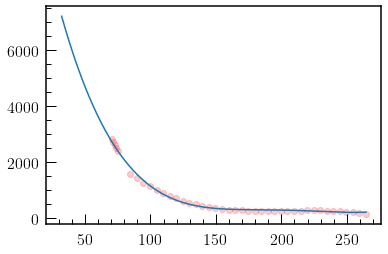

In [51]:
cx = np.concatenate((fit(z)[28:(len(fit(z))-10)], z2[8:]))
cy = np.concatenate((z[28:(len(fit(z))-10)], fit2(z2)[8:]))
plt.scatter(cx, cy, color='r', alpha=0.2)
cfit = np.poly1d(np.polyfit(cx, cy, 4))
cz = np.arange(min(min(cx), min(ica_eqw)), max(max(cx), max(ica_eqw)), 0.1)
plt.plot(cz, cfit(cz))

zfit_match = np

           4            3         2
8.219e-06 x - 0.006778 x + 2.069 x - 278 x + 1.421e+04


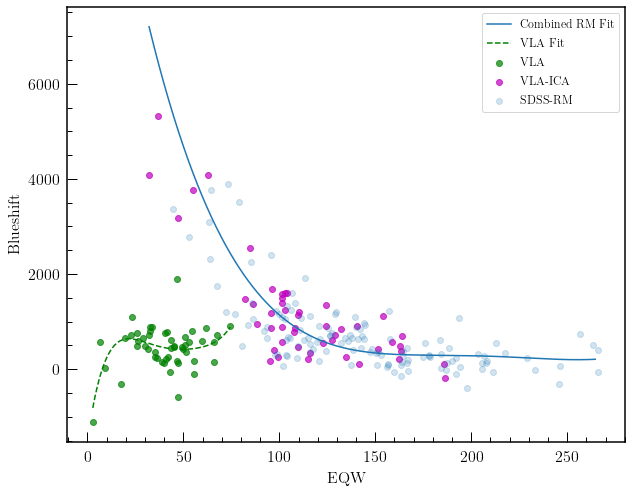

In [52]:
plt.figure(figsize=(10,8))
plt.scatter(vla_data[:,1], vla_data[:,0], label="VLA", color='g', alpha=0.7)
plt.scatter(ica_eqw, ica_blueshift, label="VLA-ICA", color='m', alpha=0.7)
plt.scatter(x2, y2, alpha=0.2, label="SDSS-RM")
plt.plot(cz, cfit(cz), label="Combined RM Fit")
plt.plot(z3, fit3(z3), '--g', label="VLA Fit")
plt.xlabel("EQW")
plt.ylabel("Blueshift")
plt.legend(loc="best")
print(cfit)

In [20]:
#Parameters to test
uniform = df2[['UNI_FLAG']].values
Miz2 = df2[['MI_Z2']].values
det = df2[['detection']].values
peak_flux = df2[['peak_flux']].values
int_flux = np.log10(df2[['int_flux']].values)
logL_rad = df2[['L_rad']].values
aro = df2[['alpha_ro']].values
ew_civ = df2[['EW_CIV_2']].values
voff_civ = df2[['VOFF_CIV_PEAK_2']].values
log_bh = df2[['LOGBH']].values
logedd_ratio = df2[['LOGEDD_RATIO']].values
logL_bol = df2[['LOGLBOL']].values
logL_civ = df2[['LOGL_CIV']].values
fwhm_civ = df2[['FWHM_CIV']].values

duni = (det>0)&(uniform>0)
nduni = (det<0)&(uniform>0)
dnuni = (det>0)&(uniform==0)
ndnuni = (det<0)&(uniform==0)

RM Size:            128
VLA Size:           50
All Data:          (178, 2)
All Data with fit: (2171, 2)


(-0.5, 1.0)

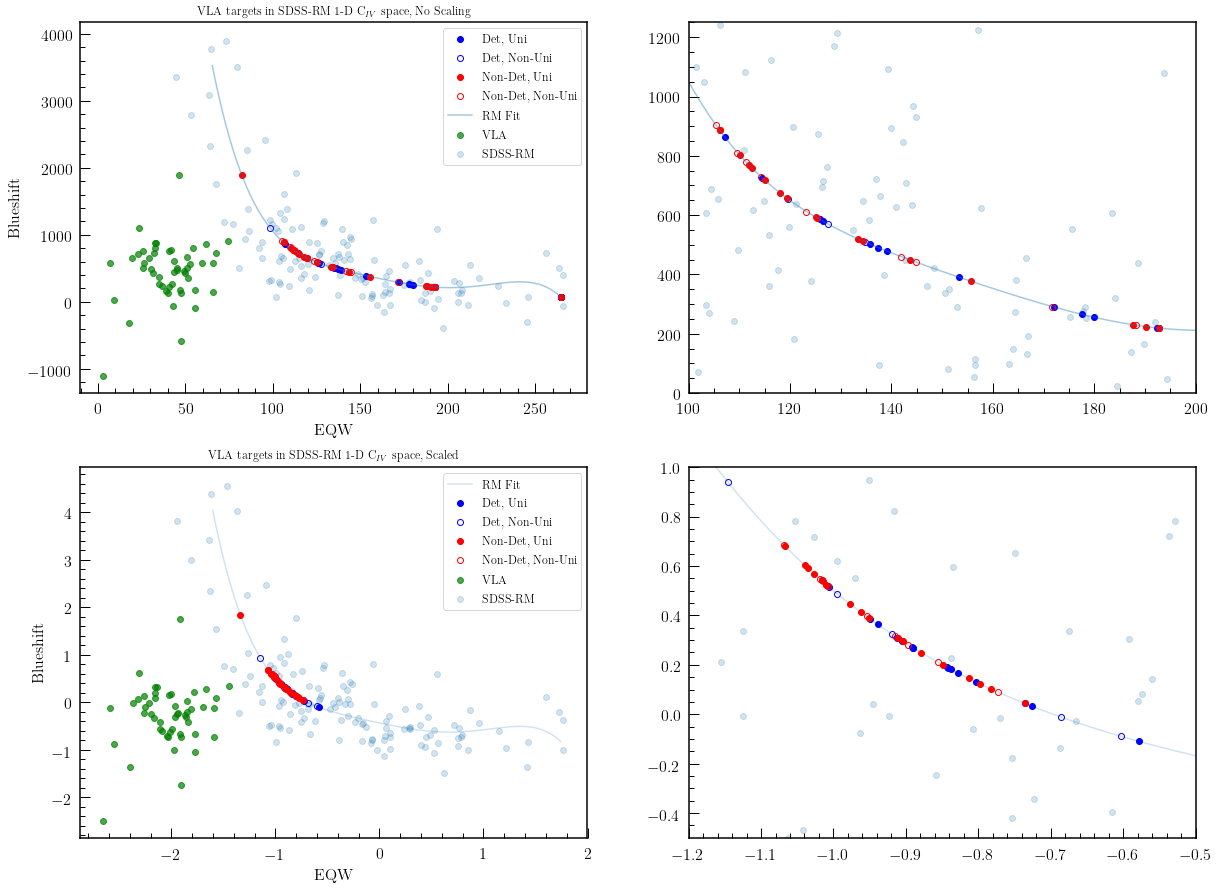

In [21]:
polyfit = np.array([cz, cfit(cz)]).T
vla_x = vla_data[:,1]
vla_y = vla_data[:,0]

tFitx, tFity = trevorFit(vla_data, polyfit)

fig, axs = plt.subplots(2, 2, figsize=(20,15))

axs[0,0].scatter(vla_x, vla_y, alpha=0.7, color="g", label="VLA")
axs[0,0].scatter(x2, y2, alpha=0.2, label="SDSS-RM")
###
axs[0,0].plot(tFitx[duni], tFity[duni], 'bo', label="Det, Uni")
axs[0,0].plot(tFitx[dnuni], tFity[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[0,0].plot(tFitx[nduni], tFity[nduni], 'ro', label="Non-Det, Uni")
axs[0,0].plot(tFitx[ndnuni], tFity[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[0,0].plot(cz, cfit(cz), alpha=0.4, label="RM Fit")
axs[0,0].set_xlabel('EQW')
axs[0,0].set_ylabel('Blueshift')
axs[0,0].set_title("VLA targets in SDSS-RM 1-D C$_{IV}$ space, No Scaling")
axs[0,0].legend(loc='best')

axs[0,1].scatter(vla_x, vla_y, alpha=0.7, color="g", label="VLA")
axs[0,1].scatter(x2, y2, alpha=0.2, label="SDSS-RM")
###
axs[0,1].plot(tFitx[duni], tFity[duni], 'bo', label="Det, Uni")
axs[0,1].plot(tFitx[dnuni], tFity[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[0,1].plot(tFitx[nduni], tFity[nduni], 'ro', label="Non-Det, Uni")
axs[0,1].plot(tFitx[ndnuni], tFity[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[0,1].plot(cz, cfit(cz), alpha=0.4)
axs[0,1].set_xlim(100,200)
axs[0,1].set_ylim(0,1250)

#Now contrast with scaled data
from sklearn.preprocessing import scale

#Want to do same scaling for both VLA and RM objects
print("RM Size:           ", len(x2))
print("VLA Size:          ", len(vla_x))
all_data = np.concatenate((X, vla_data), axis=0)
print("All Data:         ", all_data.shape)
zfit_data = np.concatenate((all_data, np.concatenate((np.atleast_2d(cfit(cz)).T, np.atleast_2d(cz).T), axis=1)), axis=0)
print("All Data with fit:", zfit_data.shape)

xsc = scale(zfit_data[:,1]) #EQW is in second column
ysc = scale(zfit_data[:,0])

vla_xsc = xsc[128:178]
vla_ysc = ysc[128:178]
rm_xsc = xsc[:128]
rm_ysc = ysc[:128]
fit_xsc = xsc[178:]
fit_ysc = ysc[178:]

#Now handle morphed together best fit line
tFitxsc, tFitysc = trevorFit(np.array([vla_ysc, vla_xsc]).T, np.array([fit_xsc, fit_ysc]).T)

axs[1,0].scatter(vla_xsc, vla_ysc, alpha=0.7, color="g", label="VLA")
axs[1,0].scatter(rm_xsc, rm_ysc, alpha=0.2, label="SDSS-RM")
axs[1,0].plot(fit_xsc, fit_ysc, alpha=0.2, label="RM Fit")
###
axs[1,0].plot(tFitxsc[duni], tFitysc[duni], 'bo', label="Det, Uni")
axs[1,0].plot(tFitxsc[dnuni], tFitysc[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[1,0].plot(tFitxsc[nduni], tFitysc[nduni], 'ro', label="Non-Det, Uni")
axs[1,0].plot(tFitxsc[ndnuni], tFitysc[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[1,0].set_xlabel('EQW')
axs[1,0].set_ylabel('Blueshift')
axs[1,0].set_title("VLA targets in SDSS-RM 1-D C$_{IV}$ space, Scaled")
axs[1,0].legend(loc="best")

axs[1,1].scatter(vla_xsc, vla_ysc, alpha=0.7, color="g", label="VLA")
axs[1,1].scatter(rm_xsc, rm_ysc, alpha=0.2, label="SDSS-RM")
axs[1,1].plot(fit_xsc, fit_ysc, alpha=0.2, label="RM Fit")
###
axs[1,1].plot(tFitxsc[duni], tFitysc[duni], 'bo', label="Det, Uni")
axs[1,1].plot(tFitxsc[dnuni], tFitysc[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[1,1].plot(tFitxsc[nduni], tFitysc[nduni], 'ro', label="Non-Det, Uni")
axs[1,1].plot(tFitxsc[ndnuni], tFitysc[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[1,1].set_xlim(-1.2,-0.5)
axs[1,1].set_ylim(-0.5,1.0)

Now want to split distance along this line into "sections", so that we can order our data analysis based on targets' location along this line

In [22]:
#create equally spaced 'bins' along scaled line of best fit
#ideally results in our data split into ~5 different bins
Lfit = spaghettify(polyfit)
marks = np.linspace(0, Lfit, 28)
markers, bins_noscale = spaghettify(polyfit, marks, tFitx)

Lscfit = spaghettify(np.array([fit_xsc, fit_ysc]).T)
scmarks = np.linspace(0, Lscfit, 28)
scmarkers, bins_scale = spaghettify(np.array([fit_xsc, fit_ysc]).T, scmarks, tFitxsc)

(-0.5, 1.0)

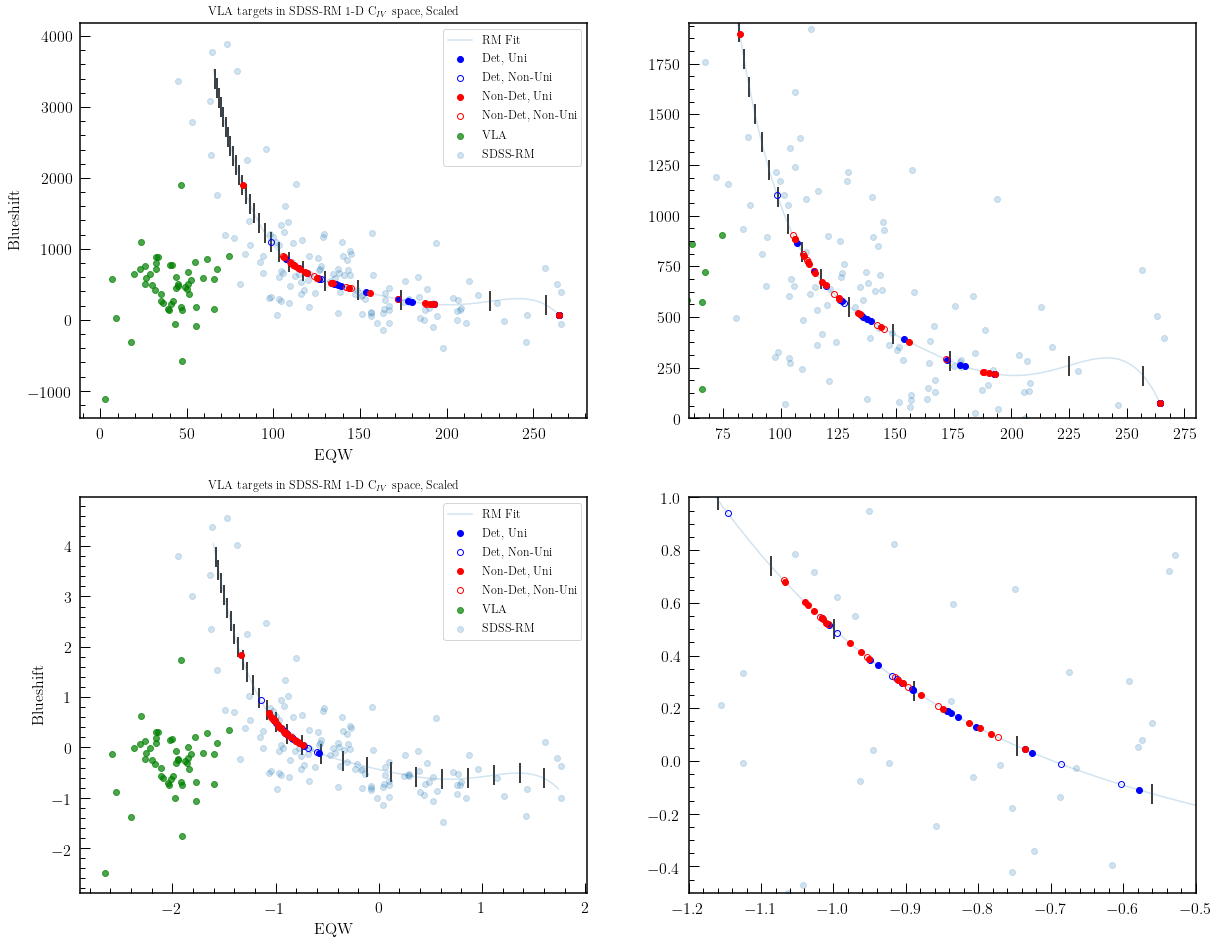

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(20,16))

#Bin coordinates
xbin = markers[:,0]
ybin = markers[:,1]

axs[0,0].scatter(xbin, ybin, color="k", marker="|", s=400)
axs[0,0].scatter(vla_x, vla_y, alpha=0.7, color="g", label="VLA")
axs[0,0].scatter(x2, y2, alpha=0.2, label="SDSS-RM")
axs[0,0].plot(cz, cfit(cz), alpha=0.2, label="RM Fit")
###
axs[0,0].plot(tFitx[duni], tFity[duni], 'bo', label="Det, Uni")
axs[0,0].plot(tFitx[dnuni], tFity[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[0,0].plot(tFitx[nduni], tFity[nduni], 'ro', label="Non-Det, Uni")
axs[0,0].plot(tFitx[ndnuni], tFity[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[0,0].set_xlabel('EQW')
axs[0,0].set_ylabel('Blueshift')
axs[0,0].set_title("VLA targets in SDSS-RM 1-D C$_{IV}$ space, Scaled")
axs[0,0].legend(loc="best")

axs[0,1].scatter(xbin, ybin, color="k", marker="|", s=400)
axs[0,1].scatter(vla_x, vla_y, alpha=0.7, color="g", label="VLA")
axs[0,1].scatter(x2, y2, alpha=0.2, label="SDSS-RM")
axs[0,1].plot(cz, cfit(cz), alpha=0.2, label="RM Fit")
###
axs[0,1].plot(tFitx[duni], tFity[duni], 'bo', label="Det, Uni")
axs[0,1].plot(tFitx[dnuni], tFity[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[0,1].plot(tFitx[nduni], tFity[nduni], 'ro', label="Non-Det, Uni")
axs[0,1].plot(tFitx[ndnuni], tFity[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[0,1].set_xlim(60,280)
axs[0,1].set_ylim(0,1950)

#Bin coordinates
xscbin = scmarkers[:,0]
yscbin = scmarkers[:,1]

axs[1,0].scatter(xscbin, yscbin, color="k", marker="|", s=400)
axs[1,0].scatter(vla_xsc, vla_ysc, alpha=0.7, color="g", label="VLA")
axs[1,0].scatter(rm_xsc, rm_ysc, alpha=0.2, label="SDSS-RM")
axs[1,0].plot(fit_xsc, fit_ysc, alpha=0.2, label="RM Fit")
###
axs[1,0].plot(tFitxsc[duni], tFitysc[duni], 'bo', label="Det, Uni")
axs[1,0].plot(tFitxsc[dnuni], tFitysc[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[1,0].plot(tFitxsc[nduni], tFitysc[nduni], 'ro', label="Non-Det, Uni")
axs[1,0].plot(tFitxsc[ndnuni], tFitysc[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[1,0].set_xlabel('EQW')
axs[1,0].set_ylabel('Blueshift')
axs[1,0].set_title("VLA targets in SDSS-RM 1-D C$_{IV}$ space, Scaled")
axs[1,0].legend(loc="best")

axs[1,1].scatter(xscbin, yscbin, color="k", marker="|", s=400)
axs[1,1].scatter(vla_xsc, vla_ysc, alpha=0.7, color="g", label="VLA")
axs[1,1].scatter(rm_xsc, rm_ysc, alpha=0.2, label="SDSS-RM")
axs[1,1].plot(fit_xsc, fit_ysc, alpha=0.2, label="RM Fit")
###
axs[1,1].plot(tFitxsc[duni], tFitysc[duni], 'bo', label="Det, Uni")
axs[1,1].plot(tFitxsc[dnuni], tFitysc[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[1,1].plot(tFitxsc[nduni], tFitysc[nduni], 'ro', label="Non-Det, Uni")
axs[1,1].plot(tFitxsc[ndnuni], tFitysc[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[1,1].set_xlim(-1.2,-0.5)
axs[1,1].set_ylim(-0.5,1.0)

#plt.savefig("../Graphs/RM_CIV_Ordering/civ_bin_visualization.png")

Lines above are edges of bins--equidistant *along fit*

Now we want to (done now):
1. Number the bins inside the spaghettify function
2. Return list of bin numbers, only if markers is given
3. Save list/array as csv

In [24]:
df2['Q_CIV_NOSCALE'] = bins_noscale
df2['Q_CIV_SCALE'] = bins_scale

In [ ]:
#df2[['Q_CIV_NOSCALE', 'Q_CIV_SCALE']].to_csv('SDSSRM_CIVdist.csv', index=False)

Now we can load in the sorted arrays with the above file to order our objects based on their location along this line

----

# Flipped axes

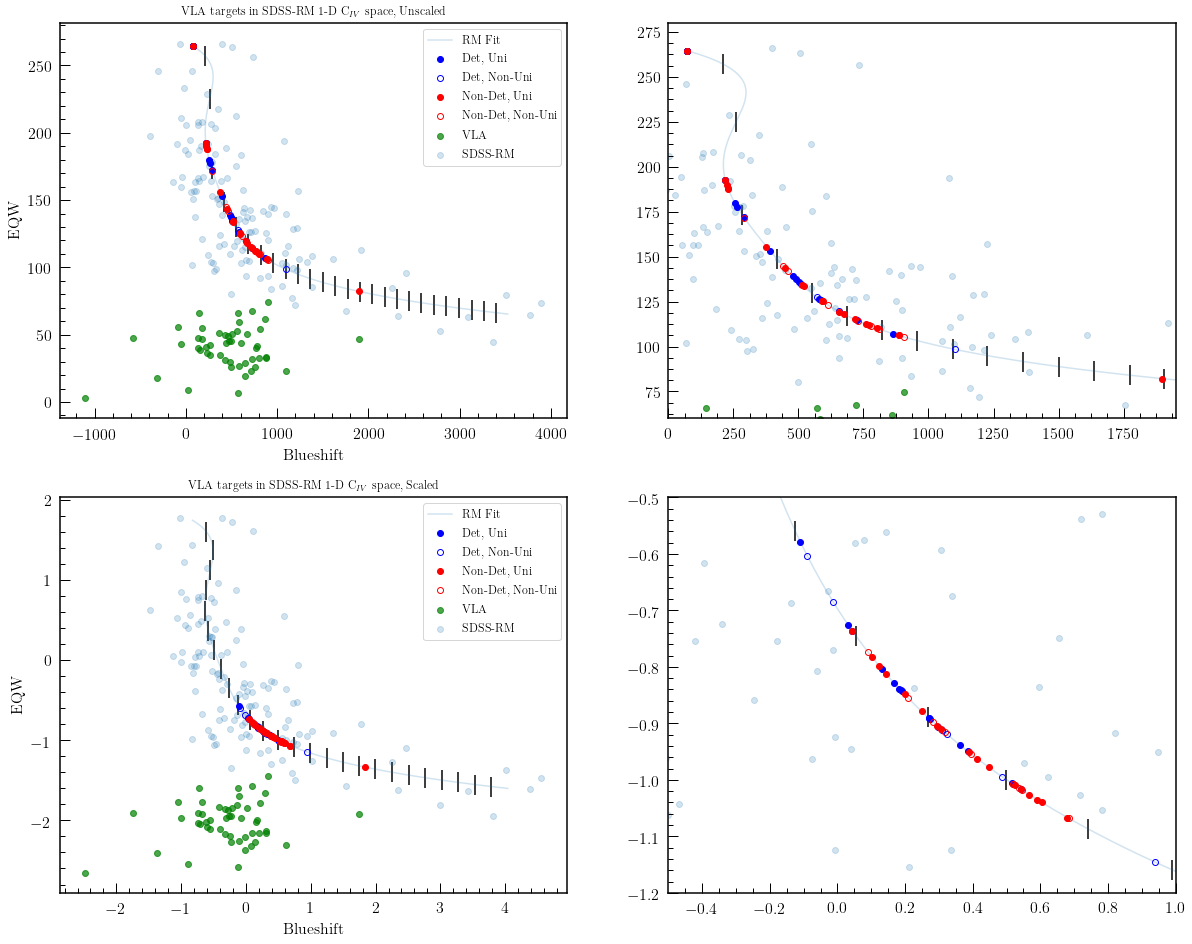

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(20,16))

#Bin coordinates
xbin = markers[:,0]
ybin = markers[:,1]

axs[0,0].scatter(ybin, xbin, color="k", marker="|", s=400)
axs[0,0].scatter(vla_y, vla_x, alpha=0.7, color="g", label="VLA")
axs[0,0].scatter(y2, x2, alpha=0.2, label="SDSS-RM")
axs[0,0].plot(cfit(cz), cz, alpha=0.2, label="RM Fit")
###
axs[0,0].plot(tFity[duni], tFitx[duni], 'bo', label="Det, Uni")
axs[0,0].plot(tFity[dnuni], tFitx[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[0,0].plot(tFity[nduni], tFitx[nduni], 'ro', label="Non-Det, Uni")
axs[0,0].plot(tFity[ndnuni], tFitx[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[0,0].set_ylabel('EQW')
axs[0,0].set_xlabel('Blueshift')
axs[0,0].set_title("VLA targets in SDSS-RM 1-D C$_{IV}$ space, Unscaled")
axs[0,0].legend(loc="best")

axs[0,1].scatter(ybin, xbin, color="k", marker="|", s=400)
axs[0,1].scatter(vla_y, vla_x, alpha=0.7, color="g", label="VLA")
axs[0,1].scatter(y2, x2, alpha=0.2, label="SDSS-RM")
axs[0,1].plot(cfit(cz), cz, alpha=0.2, label="RM Fit")
###
axs[0,1].plot(tFity[duni], tFitx[duni], 'bo', label="Det, Uni")
axs[0,1].plot(tFity[dnuni], tFitx[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[0,1].plot(tFity[nduni], tFitx[nduni], 'ro', label="Non-Det, Uni")
axs[0,1].plot(tFity[ndnuni], tFitx[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[0,1].set_ylim(60,280)
axs[0,1].set_xlim(0,1950)

#Bin coordinates
xscbin = scmarkers[:,0]
yscbin = scmarkers[:,1]

axs[1,0].scatter(yscbin, xscbin, color="k", marker="|", s=400)
axs[1,0].scatter(vla_ysc, vla_xsc, alpha=0.7, color="g", label="VLA")
axs[1,0].scatter(rm_ysc, rm_xsc, alpha=0.2, label="SDSS-RM")
axs[1,0].plot(fit_ysc, fit_xsc, alpha=0.2, label="RM Fit")
###
axs[1,0].plot(tFitysc[duni], tFitxsc[duni], 'bo', label="Det, Uni")
axs[1,0].plot(tFitysc[dnuni], tFitxsc[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[1,0].plot(tFitysc[nduni], tFitxsc[nduni], 'ro', label="Non-Det, Uni")
axs[1,0].plot(tFitysc[ndnuni], tFitxsc[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[1,0].set_ylabel('EQW')
axs[1,0].set_xlabel('Blueshift')
axs[1,0].set_title("VLA targets in SDSS-RM 1-D C$_{IV}$ space, Scaled")
axs[1,0].legend(loc="best")

axs[1,1].scatter(yscbin, xscbin, color="k", marker="|", s=400)
axs[1,1].scatter(vla_ysc, vla_xsc, alpha=0.7, color="g", label="VLA")
axs[1,1].scatter(rm_ysc, rm_xsc, alpha=0.2, label="SDSS-RM")
axs[1,1].plot(fit_ysc, fit_xsc, alpha=0.2, label="RM Fit")
###
axs[1,1].plot(tFitysc[duni], tFitxsc[duni], 'bo', label="Det, Uni")
axs[1,1].plot(tFitysc[dnuni], tFitxsc[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[1,1].plot(tFitysc[nduni], tFitxsc[nduni], 'ro', label="Non-Det, Uni")
axs[1,1].plot(tFitysc[ndnuni], tFitxsc[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[1,1].set_ylim(-1.2,-0.5)
axs[1,1].set_xlim(-0.5,1.0)

plt.savefig("../Graphs/RM_CIV_Ordering/civ_bin_visualization.pdf")